In [1]:
import os
import io
import time
from datetime import datetime

from PIL import Image
import win32clipboard

from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.action_chains import ActionChains
from selenium.common.exceptions import TimeoutException, NoSuchElementException, NoAlertPresentException

from webdriver_manager.chrome import ChromeDriverManager
from urllib.parse import urlparse

In [2]:
expedia_url = "https://console.vap.expedia.com/analytics-console-user-interface/optics/agentRealtime"
teams_url = "https://teams.microsoft.com/"
# group_chat_name = "Huu Chinh Nguyen"
parsed_url = urlparse(expedia_url)
path_fragment = parsed_url.path.split('/')[-1]
report_name = "Realtime outage"
wait_seconds = 10
start_time = datetime.now()

chrome_options = Options()
chrome_options.add_argument(r'--user-data-dir=C:/temp/new_chrome_profile')
chrome_options.add_argument(r'--profile-directory=Default')
chrome_options.add_argument("--start-maximized")

service = Service(ChromeDriverManager().install())


service = Service(r"C:\Users\huuchinh.nguyen\Concentrix Corporation\WFM-Expedia-HCM - Branding files\Rawdata\CAPTURE\chromedriver-win64\chromedriver.exe") 
driver = webdriver.Chrome(service=service, options=chrome_options)


def send_to_clipboard(image):
    output = io.BytesIO()
    image.convert("RGB").save(output, "BMP")
    data = output.getvalue()[14:]
    output.close()

    win32clipboard.OpenClipboard()
    win32clipboard.EmptyClipboard()
    win32clipboard.SetClipboardData(win32clipboard.CF_DIB, data)
    win32clipboard.CloseClipboard()
    print("Image copied to clipboard!")
    

wait = WebDriverWait(driver, 15)
driver.get(expedia_url)

def check_and_login(driver, expedia_url, wait_time=10):
    driver.get(expedia_url)
    time.sleep(10)  # Let the page load

    try:
        sign_in_button = WebDriverWait(driver, 10).until(
            EC.element_to_be_clickable((By.CSS_SELECTOR, 'button[data-testid="console-okta-sign-in"]'))
        )
        print("🔑 Sign-in required detected! Clicking...")
        sign_in_button.click()
        time.sleep(5)
        try:
            keep_signed_in_label = WebDriverWait(driver, 10).until(
                EC.element_to_be_clickable((By.CSS_SELECTOR, 'label[for="input36"][data-se-for-name="rememberMe"]'))
            )
            keep_signed_in_label.click()
            time.sleep(5)
        except TimeoutException:
            print("No 'Keep me signed in' option found. Skipping.")
        try:
            next_button = WebDriverWait(driver, 10).until(
                EC.element_to_be_clickable((By.CSS_SELECTOR, 'input.button.button-primary[type="submit"][value="Next"]'))
            )
            next_button.click()
            time.sleep(10)
        except TimeoutException:
            print("No 'Next' button found. Skipping.")
        print("🎉 Login successful! Reloading the page...")
        try:
            alert = driver.switch_to.alert
            alert.accept()  # Bấm nút OK trên alert
        except NoAlertPresentException:
            print("No 'Alert' button found. Skipping.")

        driver.get(expedia_url)
    except TimeoutException:
        print("✅ No sign-in required. Continuing with expedia_url...")

check_and_login(driver, expedia_url)

wait = WebDriverWait(driver, 10)

try:
    settings_buttons = wait.until(lambda d: d.find_elements(By.CSS_SELECTOR, "button.settingsButton"))
    if len(settings_buttons) >= 2:
        settings_buttons[0].click()
    else:
        raise TimeoutException("Không tìm thấy nút Settings thứ 2")

    wait.until(EC.presence_of_element_located((By.CSS_SELECTOR, "div.uitk-menu-container[aria-hidden='false']")))

    download_csv_button = wait.until(
        EC.element_to_be_clickable(
            (By.XPATH, "//div[@class='uitk-menu-container uitk-menu-open uitk-menu-pos-left uitk-menu-container-autoposition'][@aria-hidden='false']//button[contains(@class, 'uitk-list-item')]//span[text()='Download CSV']/ancestor::button")
        )
    )
    download_csv_button.click()

except TimeoutException:
    pass

wait = WebDriverWait(driver, 10)
wait.until(EC.url_contains(path_fragment))
time.sleep(wait_seconds)

🔑 Sign-in required detected! Clicking...
🎉 Login successful! Reloading the page...
No 'Alert' button found. Skipping.


In [3]:
import shutil
import glob 

source_folder = r"C:\Users\huuchinh.nguyen\Downloads"
destination_folder = r"C:\Users\huuchinh.nguyen\Concentrix Corporation\WFM-Expedia-HCM - Branding files\Rawdata\CAPTURE\current_agent"

file_patterns = [os.path.join(source_folder, "Current Agents*.csv"),
                 os.path.join(source_folder, "Current Agents*.xlsx")]

for pattern in file_patterns:
    for filepath in glob.glob(pattern):
        filename = os.path.basename(filepath)
        destination_path = os.path.join(destination_folder, filename)
        shutil.move(filepath, destination_path)
        print(f"Đã chuyển: {filepath} -> {destination_path}")

Đã chuyển: C:\Users\huuchinh.nguyen\Downloads\Current Agents-Tue Jun 17 2025 15_39_37 GMT+0700 (Indochina Time).csv -> C:\Users\huuchinh.nguyen\Concentrix Corporation\WFM-Expedia-HCM - Branding files\Rawdata\CAPTURE\current_agent\Current Agents-Tue Jun 17 2025 15_39_37 GMT+0700 (Indochina Time).csv


In [5]:
import pandas as pd
import pathlib
import numpy as np
import os
from pathlib import Path
import os.path
import time
from collections import OrderedDict
import polars as pl
import pandas as pd
import pyautogui
import numpy as np
import sys


from datetime import datetime, timedelta

def convert_to_datetime(struct_time):
    return datetime(*struct_time[:6])

def input_data(data_dir):
    list_files = []
    
    for filename in pathlib.Path(data_dir).glob('**/*.*'):
        file_suffixes = filename.suffixes
        if file_suffixes and file_suffixes[-1].lower() in ['.xlsx', '.csv']:
            export_time = os.path.getmtime(filename)
            export_time_datetime = convert_to_datetime(time.localtime(export_time))
            file_name = filename.stem
            
            try:
                if file_suffixes[-1].lower() == '.xlsx':
                    df = pl.read_excel(filename)
                    if df.is_empty():
                        continue
                    df = df.with_columns([
                        pl.lit(file_name).alias('sheet_name'),
                        pl.lit(export_time_datetime).alias('Export time')
                    ])
                    list_files.append(df)
                    
                elif file_suffixes[-1].lower() == '.csv':
                    if os.path.getsize(filename) == 0:
                        continue
                    df = pl.read_csv(filename)
                    if df.is_empty():
                        continue
                    df = df.with_columns([
                        pl.lit(file_name).alias('sheet_name'),
                        pl.lit(export_time_datetime).alias('Export time')
                    ])
                    list_files.append(df)
            except Exception as e:
                continue
                
    if list_files:
        return pl.concat(list_files)
    else:
        return pl.DataFrame()
    
outage_db = input_data('current_agent')
outage_db = outage_db.sort(["Export time"])
outage_db = outage_db.filter(pl.col("Export time") == pl.col("Export time").max())

outage_db = outage_db.select(['Business Location','Export time', 'Agent Name','Agent Manager','State','Assigned Workitem Count','Duration', 'Queue Group / Routing Profile'])
outage_db = outage_db.with_columns(pl.col('Duration').str.strptime(pl.Time, format='%H:%M:%S'))
outage_db = (outage_db.with_columns(
    pl.when(pl.col("Queue Group / Routing Profile").is_in(["Chat_OD_EN_Car_Activity", "Chat_OD_EN_Lodging", "Chat - Global English Lodging Nesting", "Chat_Lodging English w Car"])).then(pl.lit("Lodging Chat"))
    .when(pl.col("Queue Group / Routing Profile").is_in(["Chat - Global English Non- Lodging Nesting", "Chat_OD_EN_Dual_GDS"])).then(pl.lit("Non Lodging Chat")).otherwise(None).alias("LOB")))

hcm_outage = outage_db.filter(pl.col("Business Location") == "Concentrix (Ho Chi Minh City)")

duration_seconds = (
    pl.col("Duration").dt.hour().cast(pl.Int32) * 3600 +
    pl.col("Duration").dt.minute().cast(pl.Int32) * 60 +
    pl.col("Duration").dt.second().cast(pl.Int32)
)

hcm_outage = hcm_outage.with_columns(duration_seconds.alias("duration_seconds"))

break_lunch_outage = hcm_outage.filter(
    pl.col("State").is_in(["BREAK-IDLE", "LUNCH-IDLE"])
).with_columns(
    pl.when((pl.col("State") == "BREAK") & (pl.col("Assigned Workitem Count").is_null()) &(pl.col("duration_seconds") > 15 * 60))
    .then(pl.lit("over-break"))
    .when((pl.col("State") == "LUNCH") & (pl.col("Assigned Workitem Count").is_null()) & (pl.col("duration_seconds") > 60 * 60))
    .then(pl.lit("over-lunch"))
    .otherwise(None)
    .alias("Note")
)

coaching_training_outage = hcm_outage.filter(
    pl.col("State").is_in(["COACHING-IDLE", "TRAINING-IDLE"])
).with_columns(
    pl.lit("need to check").alias("Note")
)

active_outage = hcm_outage.filter(
    pl.col("State").is_in(["AVAILABLECHAT", "OFFLINE"])
).with_columns(
    pl.when((pl.col("State") == "AVAILABLECHAT") & (pl.col("Assigned Workitem Count").is_null()) & (pl.col("duration_seconds") > 30 * 60))
    .then(pl.lit("need to check"))
    .when((pl.col("State") == "OFFLINE") & (pl.col("Assigned Workitem Count") >= 1) & (pl.col("duration_seconds") > 10 * 60))
    .then(pl.lit("need to check"))
    .otherwise(None)
    .alias("Note")
)
print(active_outage.schema)
hcm_outage_dup = outage_db.with_columns(
    pl.when(
        (pl.col("Assigned Workitem Count") >= 1) | (pl.col("State") == "AVAILABLECHAT")
    ).then(pl.lit("Available"))
    .when(
        pl.col("Assigned Workitem Count").is_null() & pl.col("State").str.contains("BREAK")
    ).then(pl.lit("Break-Idle"))
    .when(
        pl.col("Assigned Workitem Count").is_null() & pl.col("State").str.contains("LUNCH")
    ).then(pl.lit("Lunch-Idle"))
    .when(
        pl.col("Assigned Workitem Count").is_null() & pl.col("State").str.contains("COACHING")
    ).then(pl.lit("Coaching-Idle"))
    .when(
        pl.col("Assigned Workitem Count").is_null() & pl.col("State").str.contains("TRAINING")
    ).then(pl.lit("Training-Idle"))
    .otherwise(pl.lit("Other"))
    .alias("Category"),

    pl.lit("all").alias("all")
)

grouped = (
    hcm_outage_dup.group_by(["Business Location", "LOB", "Category"])
    .agg(pl.col("Agent Name").n_unique().alias("Count"))
)

pivot_hcm = (
    grouped.pivot(
        values="Count",
        index=["Business Location", "LOB"],
        columns="Category"
    )
    .fill_null(0)
    .select(["Business Location", "LOB", "Available", "Break-Idle", "Lunch-Idle", "Coaching-Idle", "Training-Idle", "Other"])
    .filter(pl.col("LOB").is_not_null() & (pl.col("LOB") != ""))
    .sort(["Business Location", "LOB"])
)

def process_lc(df: pl.DataFrame) -> tuple[pl.DataFrame, int]:
    df = df.with_columns(
        pl.when(
            (pl.col("LOB") == "Lodging Chat") & (pl.col("Duration").cast(pl.Duration) >= timedelta(minutes=0))
        ).then(pl.lit(True))
         .when(
            (pl.col("LOB") == "Non Lodging Chat") & (pl.col("Duration").cast(pl.Duration) >= timedelta(minutes=0))
        ).then(pl.lit(True))
         .otherwise(False).alias("LC")
    )
    df = df.filter(pl.col("LC") == True)
    df = df.sort("Duration", descending=True)
    df_height = 1 if df.height > 1 else 0
    df = df.select(['Agent Name','Agent Manager','State','Duration','Note','LOB'])
    df = df.head(25)
    return df, df_height

break_lunch_outage_processed, break_lunch_height = process_lc(break_lunch_outage)
coaching_training_outage_processed, coaching_training_height = process_lc(coaching_training_outage)
active_outage_processed, active_height = process_lc(active_outage)

break_lunch = break_lunch_outage_processed.to_pandas()
coaching_training = coaching_training_outage_processed.to_pandas()
active = active_outage_processed.to_pandas()
pivot_ic = pivot_hcm.to_pandas()

Schema({'Business Location': String, 'Export time': Datetime(time_unit='us', time_zone=None), 'Agent Name': String, 'Agent Manager': String, 'State': String, 'Assigned Workitem Count': Int64, 'Duration': Time, 'Queue Group / Routing Profile': String, 'LOB': String, 'duration_seconds': Int32, 'Note': String})


C:\Users\huuchinh.nguyen\AppData\Local\Temp\ipykernel_11860\3410675688.py:137: DeprecationWarning: The argument `columns` for `DataFrame.pivot` is deprecated. It has been renamed to `on`.
  grouped.pivot(


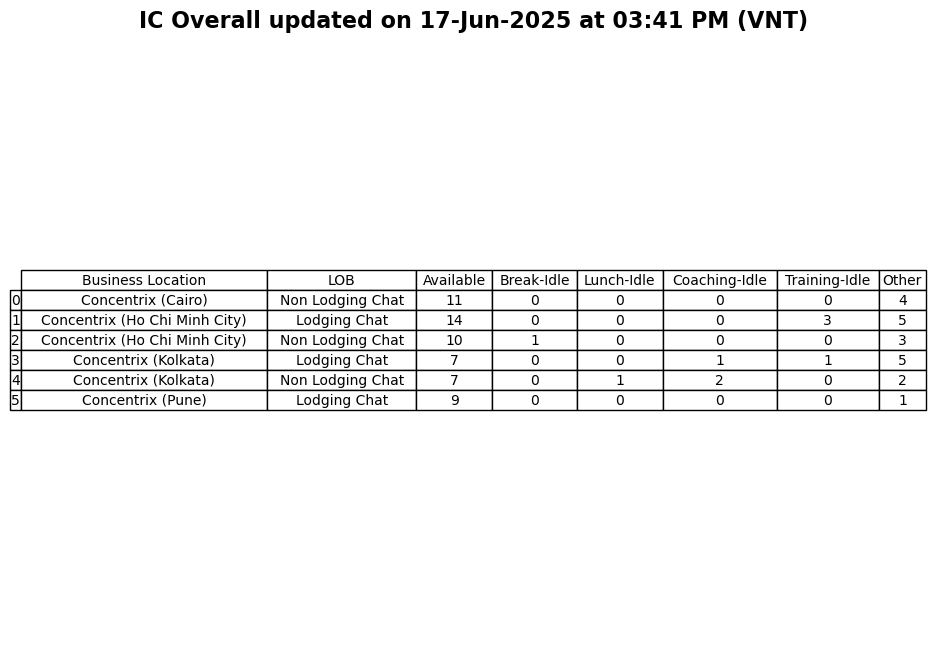

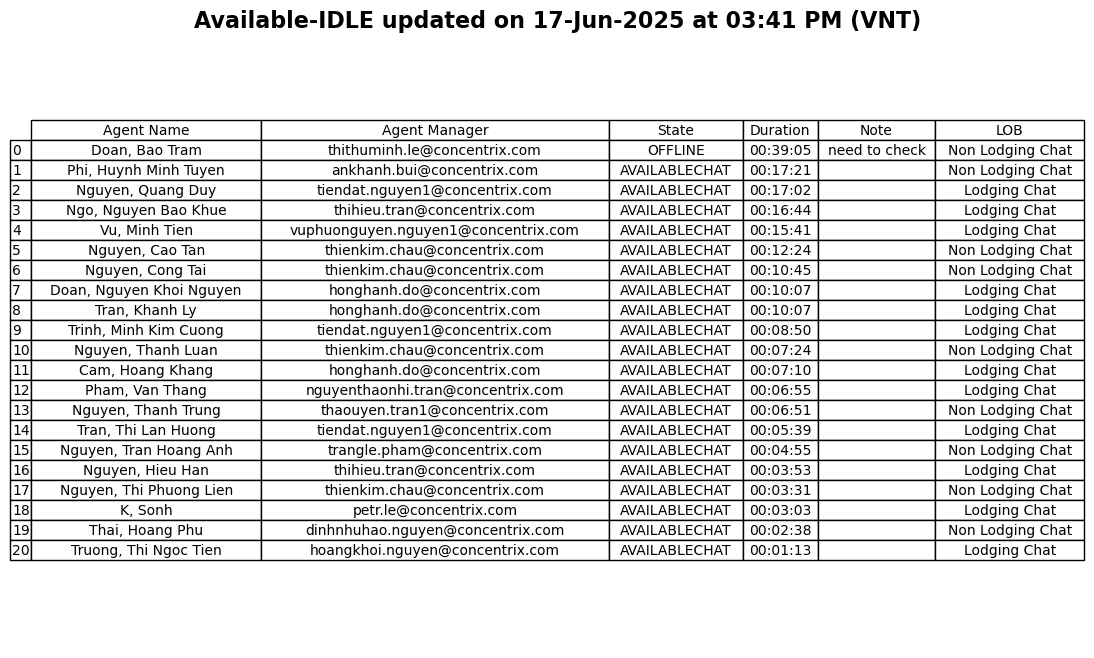

In [6]:
import matplotlib.pyplot as plt
from pandas.plotting import table
from PIL import Image
import io
import datetime

def df_to_image(df, title, is_global=False):
    now = datetime.datetime.now()
    if is_global:
        now = now - datetime.timedelta(hours=14)
    
    realtime = now.strftime("%I:%M %p")  # giờ và phút
    realtime_date = now.strftime("%d-%b-%Y")  # ngày-tháng-năm
    timezone = "(PST)" if is_global else "(VNT)"

    df_no_index = df.reset_index(drop=True)
    fig, ax = plt.subplots(figsize=(10, 8))
    ax.axis('off')
    ax.set_title(f'{title} updated on {realtime_date} at {realtime} {timezone}', fontsize=16, fontweight='bold', loc='center', pad=1)
    
    if not df_no_index.empty:
        col_widths = [max(df_no_index[col].apply(lambda x: len(str(x)))) for col in df_no_index.columns]

    tbl = table(ax, df_no_index, loc='center', cellLoc='center')
    for i, col in enumerate(df_no_index.columns):
        tbl.auto_set_column_width([i])

    tbl.auto_set_font_size(False)
    tbl.set_fontsize(10)
    tbl.scale(1.2, 1.2)
    buf = io.BytesIO()
    plt.savefig(buf, format='png', bbox_inches='tight', dpi=300)
    buf.seek(0)

    image = Image.open(buf)
    # plt.close(fig)
    return image

def save_df_image_if_not_empty(df, title, is_global=False):
    if df.empty:
        print(f"Warning: DataFrame '{title}' is empty, skipping image generation.")
        return None
    else:
        return df_to_image(df, title, is_global=is_global)

img_pivot_hcm = save_df_image_if_not_empty(pivot_ic, "IC Overall", is_global=False)
img_break_lunch = save_df_image_if_not_empty(break_lunch, "Overbreak / Overlunch", is_global=False)
img_coaching_training = save_df_image_if_not_empty(coaching_training, "Coaching / Training", is_global=False)
img_active = save_df_image_if_not_empty(active, "Available-IDLE", is_global=False)



In [7]:
from io import BytesIO
import pyperclip
import PIL.ImageGrab

def send_report_to_group(driver, teams_url, group_chat_name, report_name, image, LC_Cases, is_global=False):
    if LC_Cases == 0:
        print(f"Skipping sending report '{report_name}' because LC_Cases == 0")
        return
    send_to_clipboard(image)
    current_url = driver.current_url
    if not current_url.startswith(teams_url):
        driver.get(teams_url)
        time.sleep(5)
    wait = WebDriverWait(driver, 15)
    try:
        group_chat = wait.until(EC.presence_of_element_located((By.XPATH, f"//span[contains(text(),'{group_chat_name}')]")))
        group_chat.click()
    except Exception as e:
        print(f"Không tìm thấy nhóm chat '{group_chat_name}':", e)
        return
    time.sleep(3)
    chat_box = wait.until(EC.element_to_be_clickable((By.CSS_SELECTOR, "div[role='textbox']")))
    chat_box.click()
    now = datetime.datetime.now()
    if is_global:
        now = now - datetime.timedelta(hours=14)
    realtime = now.strftime("%I:%M %p")  
    timezone = "(PST)" if is_global else "(VNT)"
    chat_text = f"The {report_name} was updated at {realtime} {timezone}"
    actions = ActionChains(driver)
    actions.send_keys("@everyone").perform()
    time.sleep(0.5) 
    actions.send_keys(Keys.ENTER).perform()
    actions.send_keys(" ")
    actions.send_keys(chat_text)
    actions.perform()
    time.sleep(2)
    actions = ActionChains(driver)
    actions.key_down(Keys.CONTROL).send_keys('v').key_up(Keys.CONTROL).perform()
    time.sleep(2)
    actions.send_keys(Keys.ENTER).perform()
    time.sleep(10)

send_report_to_group(driver, teams_url, "[BOT] IC Monitoring", "IC Overall", img_pivot_hcm, 2, is_global=False)
send_report_to_group(driver, teams_url, "[BOT] IC Monitoring", "Break | Lunch", img_break_lunch, break_lunch_height, is_global=False)
send_report_to_group(driver, teams_url, "[BOT] IC Monitoring", "Coaching | Training", img_coaching_training, coaching_training_height, is_global=False)
send_report_to_group(driver, teams_url, "[BOT] IC Monitoring", "Available-Idle", img_active, active_height, is_global=False)

driver.quit() 

Image copied to clipboard!
Skipping sending report 'Break | Lunch' because LC_Cases == 0
Skipping sending report 'Coaching | Training' because LC_Cases == 0
Image copied to clipboard!


In [8]:
from openpyxl import Workbook, load_workbook
from datetime import datetime

end_time = datetime.now()
execution_time = (end_time - start_time).total_seconds()

log_file = "bot_log/bot_capture_log.xlsx"

if not os.path.exists(log_file):
    wb = Workbook()
    ws = wb.active
    ws.title = "Log"
    ws.append(["BOT Name", "Run at", "End at", "Execution Time (seconds)"])
else:
    wb = load_workbook(log_file)
    ws = wb["Log"]

ws.append([
    report_name,
    start_time.strftime('%Y-%m-%d %H:%M:%S'),
    end_time.strftime('%Y-%m-%d %H:%M:%S'),
    execution_time
])

wb.save(log_file)